<a href="https://colab.research.google.com/github/NeethuVenugopal/CLIP-ComputerVision/blob/main/clip_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Inference using CLIP Pretrained model

In [3]:
!pip install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.0
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --yes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.7 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7jufk5ak
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7jufk5ak
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=918898e1f2fc007ae558baa2aeeec08778e0dfa7de3c0ab1ae2263c302c7ff44
  Stored in directory: /tmp/pip-ephem-wheel-cache-53xp2yzu/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13

In [4]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("cat.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 82.7MiB/s]


Label probs: [[0.005516 0.007195 0.9873  ]]


In [5]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

100%|██████████| 169001437/169001437 [00:03<00:00, 48837466.85it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache

Top predictions:

           snake: 65.48%
          turtle: 12.30%
    sweet_pepper: 3.87%
          lizard: 1.89%
       crocodile: 1.72%


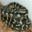

In [10]:
import IPython.display as display
display.display(image)


In [11]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Accuracy = 79.950


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
